In [17]:
#packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as ls 
from tqdm import tqdm
from scipy.signal import find_peaks
import networkx as nx 
import source_file as sf
import importlib
importlib.reload(sf)
import pickle


import matplotlib as mpl
mpl.rc('font', size=18)
mpl.rc('legend', fontsize=14)
mpl.rc('legend', numpoints=1)
mpl.rc('legend', handlelength=1.5)
mpl.rc('legend', frameon=False)
#mpl.rc('xtick.major', pad=7)
#mpl.rc('xtick.minor', pad=7)
mpl.rc('lines', lw=2)
mpl.rc('xtick',labelsize =15) 
mpl.rc('ytick',labelsize =15)


plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#### The non-Hermitian Quantum walker

$$ H_{tot} = H_{search} + V, $$

where $V = -i\kappa |w \rangle \langle w |$ and $H_{search} = - \gamma N |s\rangle\langle s| - |w\rangle\langle w | $ with $\kappa > 0$.




Question: What is the effect of the non-hermitian part in the search process, and how one can optimize it for the best search process?

There are three eigenvalues approximately

1) $-\gamma N$
2) $-1 - i\kappa$
3) $0 \quad $ $N - 2 \,\,\text{degenerate}$

The exact values are

1) $ \lambda_- = -\frac{\gamma N + 1 + i \kappa}{2}  - \sqrt{\left( \frac{\gamma N + 1 + i \kappa}{2} \right)^2 - (\gamma N - \gamma)(1 + i \kappa)}$
2) $\lambda_+ = -\frac{\gamma N + 1 + i \kappa}{2}  + \sqrt{\left( \frac{\gamma N + 1 + i \kappa}{2} \right)^2 - (\gamma N - \gamma)(1 + i \kappa)}$
3) $0 \quad $ $N - 2 \,\,\text{degenerate}$

The imaginary part will be responsible for the decrease in population from the target site and increase in population of the detector state. We want to fix $\kappa$ and try to optimize $\gamma$ so that there is maximal decrease in population from the target site.


The eigenvectors for the ground and the first excited states are:

$$|\lambda_\pm \rangle = N_\pm \left(\frac{- \lambda_\pm - \gamma(N -1)}{\gamma \sqrt{N - 1}}, 1\right)^T$$

In [147]:
#parameters
N = 1000
gamma =  2/N
w  = 10
kappa = 0.5

#Hamiltonian matrix
H = sf.H_CG(N,gamma,w,kappa)

#get the eigenvalue and right eigenstates
eigval,eigvec = np.linalg.eig(H)

#get the eigenvalue and left eigenstates
eigval_2,_ = np.linalg.eig(np.transpose(H))

#theoretical computations of the eigenvalues
lambda_plus,lambda_minus = sf.lambda_pm(N,gamma,kappa)


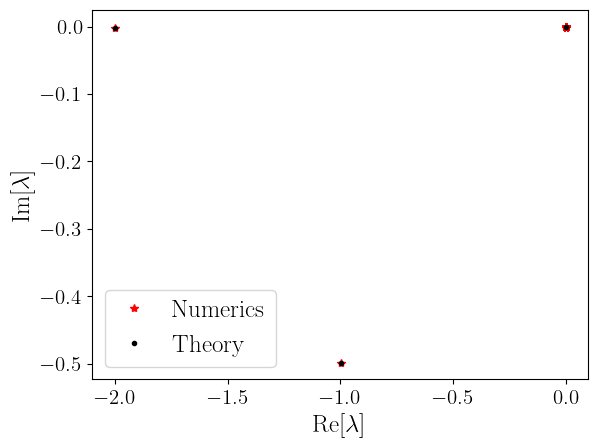

In [148]:
plt.plot(np.real(eigval),np.imag(eigval),'r*',label = 'Numerics')

plt.plot(0,0,'k.')
plt.plot(np.real(lambda_plus),np.imag(lambda_plus),'k.', label = 'Theory')
plt.plot(np.real(lambda_minus),np.imag(lambda_minus),'k.')

plt.legend(frameon = True)

plt.xlabel(r'Re$[\lambda]$')
plt.ylabel(r'Im$[\lambda]$')

plt.show()

#### The zero eigenvalue modes

In [149]:
# Sort the eigenvalues and eigenvectors
sorted_indices = np.argsort(np.real(eigval))  # Get indices for sorting eigenvalues
eigval_sorted = eigval[sorted_indices]  # Sort eigenvalues
eigvec_sorted = eigvec[:,sorted_indices]  # Reorder eigenvectors accordingly    


#compute the overlap with the initial state
psi_0 = (1.0/np.sqrt(N))*np.ones((N,1)) #initial state


sum = 0
for i in range(2,N):
    sum += np.abs(np.vdot(eigvec_sorted[:,i],psi_0))**2
    #print(np.abs(np.vdot(eigvec_sorted[:,i],psi_0))**2)

print(sum)



2.6373973760254133e-29


#### Survival Probability

The zero eigenvalue modes have negligible overlap with the initial state. Numerically it is of order ($10^{-29}$). This led to the expression of survival probability to be 


$$S(t) \approx e^{2 \rm{Im} (\lambda_-) t}\, |\langle \lambda_-|s \rangle|^2  + e^{2 \rm{Im} (\lambda_+) t}\, |\langle \lambda_+|s \rangle|^2 $$

The behavior of survival probability thus depends on these two terms. Both overlaps and the rate of decay depends on $\gamma$ and $\kappa$. 

In [221]:
#parameters
N = 500
w  = 10
kappa = np.linspace(0.001,1,500)
#gamma = np.linspace(0.0001,2/N,100)
gamma = [1.3/N]

E0s_t = np.zeros(len(kappa), dtype = complex)
E1s_t = np.zeros(len(kappa), dtype = complex)

for i in range(len(kappa)):

    #theoretical computations of the overlaps
    E0s_t[i],E1s_t[i],_,_ = sf.overlap_CG_theory(N,gamma,w,kappa[i])

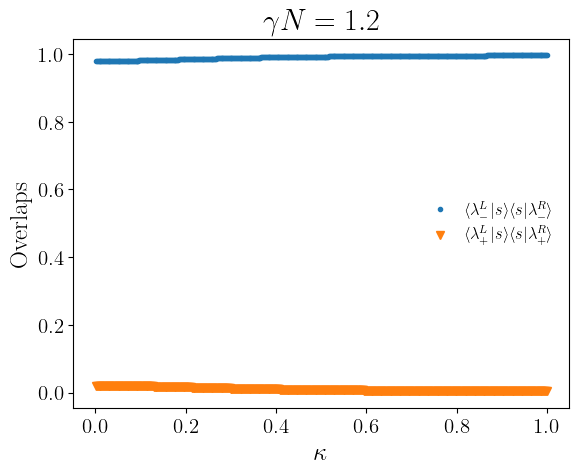

In [222]:
plt.plot(kappa, abs(E0s_t),'.',label = r'$\langle \lambda_-^L | s \rangle \langle s | \lambda_-^R \rangle$')
plt.plot(kappa, abs(E1s_t),'v',label = r'$\langle \lambda_+^L | s \rangle \langle s | \lambda_+^R \rangle$')

plt.legend(fontsize = 12)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'Overlaps')
plt.title(f'$\\gamma N = {1.2}$')

#plt.savefig(f'../Figures/Overlap_CG/Overlap_gammaN{2}.pdf',bbox_inches = 'tight',dpi =600)
plt.show()


#### Analysis  and the imaginary part of the ground state and first excited state eigenvalues

For $\gamma N \ll 1$, the survival probability is governed by

$$ S(t) \approx e^{2 \rm{Im} (\lambda_+) t}$$

For $\gamma N \gg 1$, the survival probability is governed by

$$ S(t) \approx e^{2 \rm{Im} (\lambda_-) t}$$

For $\gamma N = 1$, it is governed by both overlap and the decay rate, but for large $\kappa$, it is again given by the expression of $S(t)$ for the case of $\gamma N \ll 1$.

In [119]:
#parameters
N = 500
w  = 10
kappa = [0.01,0.1,0.25,0.5,0.75,1,10]
gamma = np.linspace(0.1/N,0.9/N,10)

lambda_plus = np.zeros((len(kappa), len(gamma)), dtype = complex)

for j in range(len(kappa)):
    for i in range(len(gamma)):

        #Hamiltonian matrix
        H = sf.H_CG(N,gamma[i],w,kappa[j])

        #get the eigenvalue and right eigenstates
        eigval,_ = np.linalg.eig(H)
        sorted_indices = np.argsort(np.real(eigval))  # Get indices for sorting eigenvalues
        eigval_sorted = eigval[sorted_indices] 

        lambda_plus[j,i] = eigval_sorted[1]

                
        #theoretical computations of the eigenvalues
        #lambda_plus[j,i],_ = sf.lambda_pm(N,gamma[i],kappa[j])

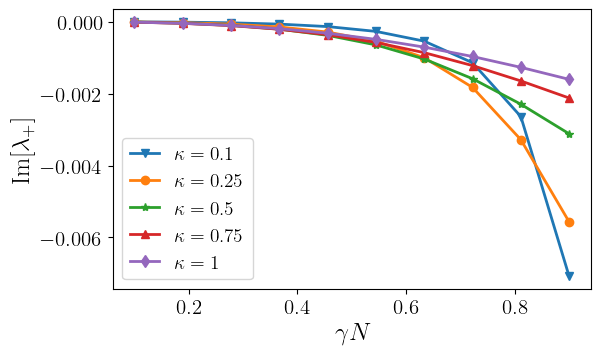

In [120]:
fig= plt.figure(figsize = (3.41667*1.4,2*1.4))
ax = fig.add_axes([0, 0, 1, 1])
#plt.plot(gamma*N, np.imag(lambda_plus[0]),'-.', label = f'$\\kappa = {kappa[0]}$')
plt.plot(gamma*N, np.imag(lambda_plus[1]),'-v', label = f'$\\kappa = {kappa[1]}$')
plt.plot(gamma*N, np.imag(lambda_plus[2]),'-o', label = f'$\\kappa = {kappa[2]}$')
plt.plot(gamma*N, np.imag(lambda_plus[3]),'-*', label = f'$\\kappa = {kappa[3]}$')
plt.plot(gamma*N, np.imag(lambda_plus[4]),'-^', label = f'$\\kappa = {kappa[4]}$')
plt.plot(gamma*N, np.imag(lambda_plus[5]),'-d', label = f'$\\kappa = {kappa[5]}$')


plt.legend(frameon = True)
plt.ylabel('Im$[\lambda_+]$')
plt.xlabel(r'$\gamma N$')
plt.savefig(f'../Figures/Presentation/imag_lambda_plus.pdf',bbox_inches ='tight', dpi =600,transparent = True)
plt.show()

In [121]:
#parameters
N = 500
w  = 10
kappa = [0.01,0.1,0.25,0.5,0.75,1,10]
gamma = np.linspace(1.1/N,2/N,10)

lambda_minus = np.zeros((len(kappa), len(gamma)), dtype = complex)

for j in range(len(kappa)):
    for i in range(len(gamma)):

        #Hamiltonian matrix
        H = sf.H_CG(N,gamma[i],w,kappa[j])

        #get the eigenvalue and right eigenstates
        eigval,_ = np.linalg.eig(H)
        sorted_indices = np.argsort(np.real(eigval))  # Get indices for sorting eigenvalues
        eigval_sorted = eigval[sorted_indices] 

        lambda_minus[j,i] = eigval_sorted[0]



        
        #theoretical computations of the eigenvalues
        #_,lambda_minus[j,i] = sf.lambda_pm(N,gamma[i],kappa[j])

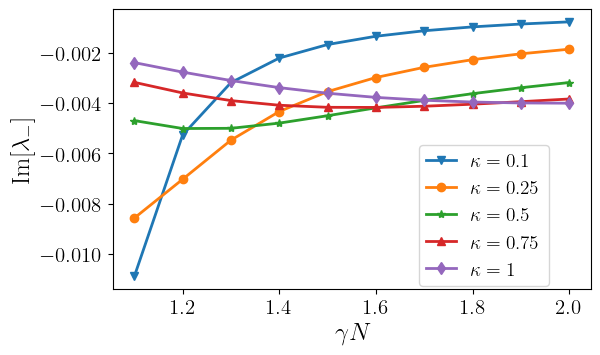

In [122]:
fig= plt.figure(figsize = (3.41667*1.4,2*1.4))
ax = fig.add_axes([0, 0, 1, 1])

#plt.plot(gamma*N, np.imag(lambda_minus[0]),'.', label = f'$\\kappa = {kappa[0]}$')
plt.plot(gamma*N, np.imag(lambda_minus[1]),'-v', label = f'$\\kappa = {kappa[1]}$')
plt.plot(gamma*N, np.imag(lambda_minus[2]),'-o', label = f'$\\kappa = {kappa[2]}$')
plt.plot(gamma*N, np.imag(lambda_minus[3]),'-*', label = f'$\\kappa = {kappa[3]}$')
plt.plot(gamma*N, np.imag(lambda_minus[4]),'-^', label = f'$\\kappa = {kappa[4]}$')
plt.plot(gamma*N, np.imag(lambda_minus[5]),'-d', label = f'$\\kappa = {kappa[5]}$')
#plt.plot(gamma*N, np.imag(lambda_minus[6]),'-d', label = f'$\\kappa = {kappa[6]}$')

plt.legend(loc = (0.64,0.01), frameon = True)
plt.ylabel('Im$[\lambda_-]$')
plt.xlabel(r'$\gamma N$')

plt.savefig(f'../Figures/Presentation/imag_lambda_minus.pdf',bbox_inches ='tight', dpi =600,transparent = True)
plt.show()

#### Check of theoretical survival probability 

There is something missing with the theoretical calculations in the neighbourhood of $\gamma N = 1$. Although, the long time behavior matches and qualitatively it behaves the same, there is a consistent mismatch in the short and intermediate time behavior !!! 

In [127]:
N = 500
w  = 10
kappa = 0.01
gamma = [0.5/N,1.0/N,1.5/N,2.0/N]

T = 400
dt = 0.01
m  = int(T/dt)


s_prob = np.zeros((len(gamma),m))

#target state
ket_w = np.zeros((N,1))
ket_w[w] = 1

for k in tqdm(range(len(gamma))):
    
    #The Hamiltonian
    H =  sf.H_CG(N,gamma[k],w,kappa)

    #initial state
    psi_0 = (1.0/np.sqrt(N))*np.ones((N,1))

    #Initial overlap
 
    s_prob[k,0] = np.abs(np.vdot(psi_0,psi_0))

    #Time Evolution operator
    ut = np.asarray(ls.expm(-(1.0j)*H*dt))

    for j in range(1,m):        

        #wavefunction after time evolution of dt
        psit = ut.dot(psi_0)    

        #survival probability

        s_prob[k,j] = np.abs(np.vdot(psit,psit))

        psi_0 = psit  

100%|██████████| 4/4 [00:10<00:00,  2.68s/it]


In [369]:
gamma = [0.5/N,1.0/N,1.5/N,2.0/N]

#theoretical computations of the overlaps
E0s_t,E1s_t,_,_ = sf.overlap_CG_theory(N,gamma,w,kappa)

lambda_plus = np.zeros(len(gamma), dtype = complex)
lambda_minus = np.zeros(len(gamma), dtype =complex)

for i in range(len(gamma)):
    #theoretical computations of the eigenvalues
    lambda_plus[i],lambda_minus[i] = sf.lambda_pm(N,gamma[i],kappa)

In [370]:
t = np.arange(0,400,0.01)
S_1 = np.zeros(m)
S_2 = np.zeros(m)
S_3 = np.zeros(m)
S_4 = np.zeros(m)

for i in range(m):
    S_1[i] = np.exp(2*np.imag(lambda_minus[0])*t[i])*abs(E0s_t[0])  + np.exp(2*np.imag(lambda_plus[0])*t[i])*abs(E1s_t[0]) 
    S_2[i] = np.exp(2*np.imag(lambda_minus[1])*t[i])*abs(E0s_t[1])  + np.exp(2*np.imag(lambda_plus[1])*t[i])*abs(E1s_t[1]) 
    S_3[i] = np.exp(2*np.imag(lambda_minus[2])*t[i])*abs(E0s_t[2])  + np.exp(2*np.imag(lambda_plus[2])*t[i])*abs(E1s_t[2]) 
    S_4[i] = np.exp(2*np.imag(lambda_minus[3])*t[i])*abs(E0s_t[3])  + np.exp(2*np.imag(lambda_plus[3])*t[i])*abs(E1s_t[3]) 

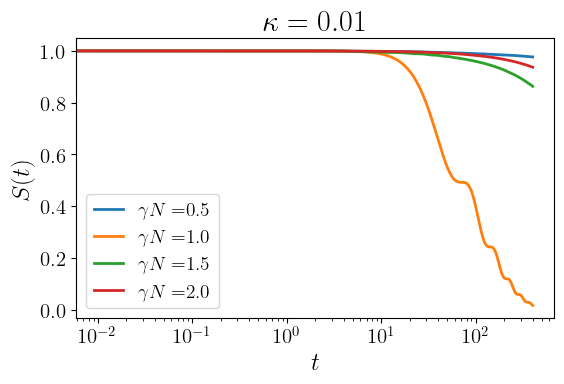

In [128]:
fig= plt.figure(figsize = (3.41667*1.4,2*1.4))
ax = fig.add_axes([0, 0, 1, 1])
plt.plot(np.arange(m)*dt,s_prob[0],label = f'$\\gamma N=${gamma[0]*N}')
#plt.plot(np.arange(m)*dt,S_1,'--',label = f'$\\gamma N=${gamma[0]*N}: TH')


plt.plot(np.arange(m)*dt,s_prob[1],label = f'$\\gamma N=${gamma[1]*N}')
#plt.plot(np.arange(m)*dt,S_2,':',label = f'$\\gamma N=${gamma[1]*N}: TH')

plt.plot(np.arange(m)*dt,s_prob[2],label = f'$\\gamma N=${gamma[2]*N}')
#plt.plot(np.arange(m)*dt,S_3,'-.',label = f'$\\gamma N=${gamma[2]*N}: TH')

plt.plot(np.arange(m)*dt,s_prob[3],label = f'$\\gamma N=${gamma[3]*N}')
#plt.plot(np.arange(m)*dt,S_4,'-.',label = f'$\\gamma N=${gamma[3]*N}: TH')


plt.legend(frameon =True,loc = 'lower left')
plt.xlabel(r'$t$')
plt.ylabel(r'$S(t)$')
plt.xscale('log')
plt.title(f'$\kappa = {kappa}$')
plt.savefig(f'../Figures/Presentation/surv_prob_kappa{kappa}.pdf',bbox_inches = 'tight', dpi = 600, transparent = True)
plt.show()

#### Overlap of the ground state and first excited state with the target and initial state

In [36]:
#parameters
N = 500
w  = 10
kappa = 1
gamma = np.linspace(0.1/N,2/N,100)

#E0s,E1s,E0w,E1w = sf.overlap_CG_numerics(N,gamma,w,kappa)
E0s_t,E1s_t,E0w_t,E1w_t = sf.overlap_CG_theory(N,gamma,w,kappa)

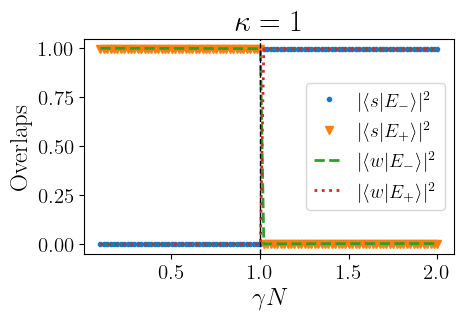

In [37]:
plt.figure(figsize = (3.41667*1.4,2*1.4))

#plt.plot(gamma*N, E0s,'*',label = r'$\langle E_0^L | s \rangle \langle s | E_0^R \rangle:$NM')
#plt.plot(gamma*N, E0s_t,'.',label = r'$\langle E_-^L | s \rangle \langle s | E_-^R \rangle$')
plt.plot(gamma*N, E0s_t,'.',label = r'$|\langle s | E_- \rangle|^2$')


#plt.plot(gamma*N, E1s,'^',label = r'$\langle E_1^L | s \rangle \langle s | E_1^R \rangle:$NM')
#plt.plot(gamma*N, E1s_t,'v',label = r'$\langle E_+^L | s \rangle \langle s | E_+^R \rangle$')
plt.plot(gamma*N, E1s_t,'v',label = r'$| \langle s | E_+ \rangle|^2$')

#plt.plot(gamma*N, E0w,'-.',label = r'$\langle E_0^L | w \rangle \langle w | E_0^R \rangle:$NM')
#plt.plot(gamma*N, E0w_t,'--',label = r'$\langle E_-^L | w \rangle \langle w | E_-^R \rangle$')
plt.plot(gamma*N, E0w_t,'--',label = r'$|\langle w | E_- \rangle|^2$')


#plt.plot(gamma*N, E1w,'-',label = r'$\langle E_1^L | w \rangle \langle w | E_1^R \rangle:$NM')
#plt.plot(gamma*N, E1w_t,':',label = r'$\langle E_+^L | w \rangle \langle w | E_+^R \rangle$')
plt.plot(gamma*N, E1w_t,':',label = r'$|\langle w | E_+ \rangle|^2$')

plt.axvline(1.0,linestyle = '--',color = 'k',linewidth =1)




plt.legend(frameon = True)
plt.xlabel(r'$\gamma N$')
plt.ylabel(r'Overlaps')
plt.title(f'$\\kappa = {kappa}$')

plt.savefig(f'../Figures/Presentation/Overlap_k{kappa}_N{N}.pdf',bbox_inches = 'tight',dpi =600,transparent = True)
plt.show()

#### Computing the maximum fidelity and corresponding T_max in the $(\gamma-\kappa)$ plane.

In [419]:
N = 500
w  = 10
kappa = np.linspace(0.01,1,100)
gamma = np.linspace(0.5/N,1.5/N,100)

T = 400
dt = 0.01
m  = int(T/dt)

f_max = np.zeros((len(kappa),len(gamma)))
T_max = np.zeros((len(kappa),len(gamma)))
sn_prob = np.zeros((len(gamma),m))

#target state
ket_w = np.zeros((N,1))
ket_w[w] = 1

for kk in tqdm(range(len(kappa))):

    for k in tqdm(range(len(gamma)),leave = True):
        
        #The Hamiltonian
        H =  sf.H_CG(N,gamma[k],w,kappa[kk])

        #initial state
        psi_0 = (1.0/np.sqrt(N))*np.ones((N,1))

        #Initial overlap
        sn_prob[k,0] = (np.abs(np.vdot(ket_w,psi_0))**2) / np.abs(np.vdot(psi_0,psi_0))

        #Time Evolution operator
        ut = np.asarray(ls.expm(-(1.0j)*H*dt))

        for j in range(1,m):        

            #wavefunction after time evolution of dt
            psit = ut.dot(psi_0)    

            # Normalized fidelity
            sn_prob[k,j] = (np.abs(np.vdot(ket_w,psit))**2) / np.abs(np.vdot(psit,psit))
            
            psi_0 = psit  
        
        f_max[kk,k] = np.max(np.round(sn_prob[k],8))
        T_max[kk,k] = np.argmax(np.round(sn_prob[k],8))*dt #argmax compute the first maxima

100%|██████████| 100/100 [2:16:27<00:00, 81.88s/it]


In [424]:
#import pickle
#with open('../Data/data_t_opt_kappa_0-1.pkl', 'wb') as f:
    #pickle.dump(T_max,f)

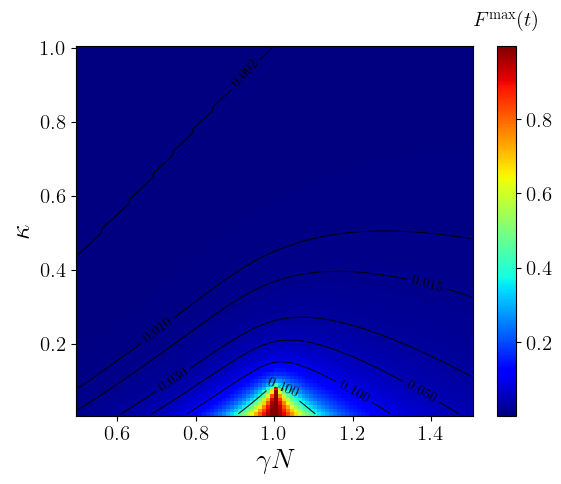

In [459]:
N = 500
kappa = np.linspace(0.01,1,100)
gamma = np.linspace(0.5/N,1.5/N,100)

x, y = np.meshgrid(gamma*N, kappa)

fig, ax = plt.subplots()
####################


minval = 0
maxval = 1


im1 = ax.pcolor(x, y, f_max, cmap='jet')

#im1 = ax.contourf(x, y, f_max, levels=np.linspace(minval, maxval,150), cmap="jet")
CS = ax.contour(x, y, f_max,levels = [0.002,0.01,0.015,0.03,0.05,0.1,0.4],colors ='black',linewidths = 0.7)
###################


cbar = fig.colorbar(
    im1,
    ax=ax,
    ticks=[0,0.2,0.4,0.6,0.8,1.0],
    orientation="vertical"
)
cbar.ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
cbar.ax.set_title(r'$F^{\rm max}(t)$', size = 15,pad = 15)

#manual_locations = [(1,2),(1,2),(1,2),(1,2),(1,2)]

#for level in CS.collections:
    #for kp,path in reversed(list(enumerate(level.get_paths()))):
        # go in reversed order due to deletions!

        # include test for "smallness" of your choice here:
        # I'm using a simple estimation for the diameter based on the
        #    x and y diameter...
        #verts = path.vertices # (N,2)-shape array of contour line coordinates
        #diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
        #print(diameter)

        #if diameter < 0.15: # threshold to be refined for your actual dimensions!
            #if remove_next:
                #del(level.get_paths()[kp])  # no remove() for Path objects:(
            #remove_next = not remove_next  # Toggle the flag

            


plt.clabel(CS, inline=True, fontsize=10)

plt.ylabel(r'$\kappa$',size = 20)
plt.xlabel(r'$\gamma N$',size = 20)

plt.gcf().canvas.draw()

#plt.savefig('../Figures/PD_fidelity_max_kappa_0-1.png',bbox_inches = 'tight',dpi =600)
plt.show()

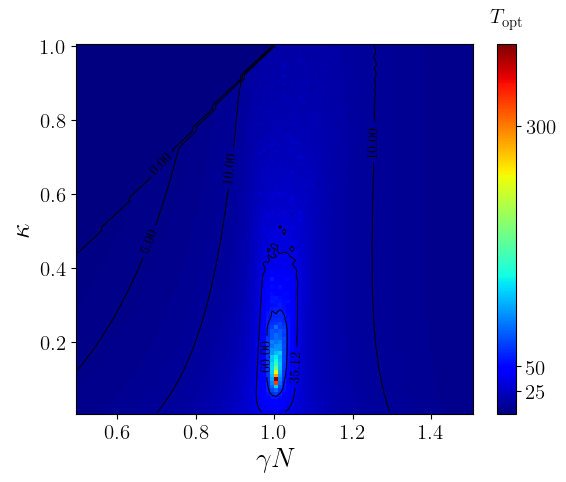

In [460]:
fig, ax = plt.subplots()
####################

minval = 0
maxval = 100

im1 = ax.pcolor(x, y, T_max,vmin = 1, cmap='jet')

#im1 = ax.contourf(x, y, T_max, levels=np.linspace(minval, maxval,150), cmap="jet")
CS = ax.contour(x, y,T_max,levels = [0,5,10,np.pi*np.sqrt(N)/2,60],colors ='black',linewidths = 0.7)
###################

cbar = fig.colorbar(
    im1,
    ax=ax,
    ticks=[0,25,50,300],
    orientation="vertical"
)
cbar.ax.set_yticklabels([0,25,50,300])
cbar.ax.set_title(r'$T_{\rm opt}$', size = 15,pad = 15)


#manual_locations = [(1,2),(1,2),(1,2),(1,2),(1,2)]

#for level in CS.collections:
   # for kp,path in reversed(list(enumerate(level.get_paths()))):
        # go in reversed order due to deletions!

        # include test for "smallness" of your choice here:
        # I'm using a simple estimation for the diameter based on the
        #    x and y diameter...
       # verts = path.vertices # (N,2)-shape array of contour line coordinates
      #  diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
      #  print(diameter)

      #  if diameter != 1999998.0981764845 and diameter != 1980728.364805822 : # threshold to be refined for your actual dimensions!
       #     del(level.get_paths()[kp])  # no remove() for Path objects:(


plt.clabel(CS, inline=True, fontsize=10)

plt.ylabel(r'$\kappa$',size = 20)
plt.xlabel(r'$\gamma N$',size = 20)

plt.gcf().canvas.draw()
N = 500
kappa = np.linspace(0.01,1,100)
gamma = np.linspace(0.5/N,1.5/N,100)

x, y = np.meshgrid(gamma*N, kappa)

fig, ax = plt.subplots()
####################


minval = 0
maxval = 1


im1 = ax.pcolor(x, y, f_max, cmap='jet')

#im1 = ax.contourf(x, y, f_max, levels=np.linspace(minval, maxval,150), cmap="jet")
CS = ax.contour(x, y, f_max,levels = [0.002,0.01,0.015,0.03,0.05,0.1,0.4],colors ='black',linewidths = 0.7)
###################


cbar = fig.colorbar(
    im1,
    ax=ax,
    ticks=[0,0.2,0.4,0.6,0.8,1.0],
    orientation="vertical"
)
cbar.ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
cbar.ax.set_title(r'$F^{\rm max}(t)$', size = 15,pad = 15)

#manual_locations = [(1,2),(1,2),(1,2),(1,2),(1,2)]

#for level in CS.collections:
    #for kp,path in reversed(list(enumerate(level.get_paths()))):
        # go in reversed order due to deletions!

        # include test for "smallness" of your choice here:
        # I'm using a simple estimation for the diameter based on the
        #    x and y diameter...
        #verts = path.vertices # (N,2)-shape array of contour line coordinates
        #diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
        #print(diameter)

        #if diameter < 0.15: # threshold to be refined for your actual dimensions!
            #if remove_next:
                #del(level.get_paths()[kp])  # no remove() for Path objects:(
            #remove_next = not remove_next  # Toggle the flag

            


plt.clabel(CS, inline=True, fontsize=10)

plt.ylabel(r'$\kappa$',size = 20)
plt.xlabel(r'$\gamma N$',size = 20)

plt.gcf().canvas.draw()

#plt.savefig('../Figures/PD_fidelity_max_kappa_0-1.png',bbox_inches = 'tight',dpi =600)
plt.show()
plt.savefig('../Figures/PD_T_opt_kappa_0-1.png',bbox_inches = 'tight',dpi =600)

plt.show()



In [444]:
Q1 = np.zeros((len(kappa),len(gamma)))

for i in range(len(kappa)):
    for j in range(len(gamma)):

        Q1[i,j] = T_max[i,j]/f_max[i,j]

/tmp/ipykernel_1624768/1510765813.py:8: RuntimeWarning: divide by zero encountered in log
  maxval = np.max(np.log(Q1_masked))
/tmp/ipykernel_1624768/1510765813.py:11: RuntimeWarning: divide by zero encountered in log10
  im1 = ax.pcolor(x, y, np.log10(Q1_masked), cmap='jet')


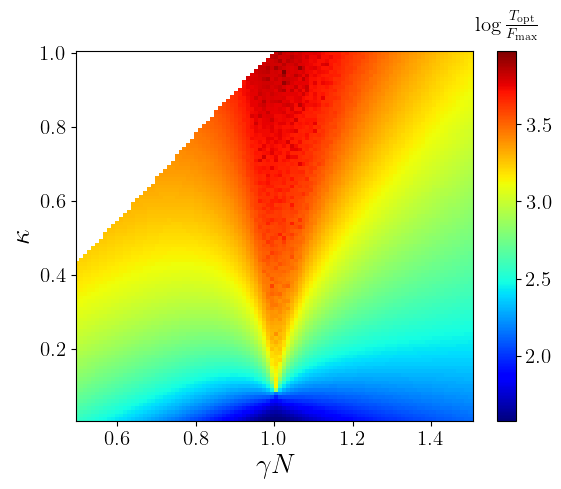

In [461]:
fig, ax = plt.subplots()
####################

# Mask out regions where z2 equals zero
Q1_masked = np.ma.masked_where(Q1== 0, Q1)

minval = np.log(0.01)
maxval = np.max(np.log(Q1_masked))

#im1 = ax.contourf(x, y, Q, levels=np.linspace(minval, maxval,150), cmap="jet")
im1 = ax.pcolor(x, y, np.log10(Q1_masked), cmap='jet')


#CS = ax.contour(x, y,Q,20,colors ='black',linewidths = 0.7)
###################

cbar = fig.colorbar(
    im1,
    ax=ax,
    #ticks=[0,1000,2000,3000,4000],
    orientation="vertical"
)
#cbar.ax.set_yticklabels([0,1000,2000,3000,4000])
cbar.ax.set_title(r'$\log \frac{T_{\rm opt}}{F_{\rm max}}$', size = 15,pad = 15)

# Overlay striped pattern on regions where z2 is zero
#ax.contourf(x, y, Q, levels=[0.5, 1.5], colors='none', hatches=['\\'], extend='both')


#manual_locations = [(1,2),(1,2),(1,2),(1,2),(1,2)]

#for level in CS.collections:
   # for kp,path in reversed(list(enumerate(level.get_paths()))):
        # go in reversed order due to deletions!

        # include test for "smallness" of your choice here:
        # I'm using a simple estimation for the diameter based on the
        #    x and y diameter...
       # verts = path.vertices # (N,2)-shape array of contour line coordinates
      #  diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
      #  print(diameter)

      #  if diameter != 1999998.0981764845 and diameter != 1980728.364805822 : # threshold to be refined for your actual dimensions!
       #     del(level.get_paths()[kp])  # no remove() for Path objects:(


#plt.clabel(CS, inline=True, fontsize=10)

plt.ylabel(r'$\kappa$',size = 20)
plt.xlabel(r'$\gamma N$',size = 20)

plt.gcf().canvas.draw()


plt.savefig('../Figures/PD_complexity_kappa_0-1.png',bbox_inches = 'tight',dpi =600)
#plt.savefig('PD_presentation_N_1000.png',bbox_inches = 'tight',dpi =600)
plt.show()


#### Study the survival probability and the fidelity phase diagram as a function of time and $\kappa$ for three different values of $\gamma N$

In [363]:
N = 500
w  = 10
kappa = np.linspace(0.01,1,100)
gamma = [0.5/N, 1.0/N, 1.5/N]

T = 400
dt = 0.01
m  = int(T/dt)

w_prob = np.zeros((len(gamma),len(kappa),m))
s_prob = np.zeros((len(gamma),len(kappa),m))

#target state
ket_w = np.zeros((N,1))
ket_w[w] = 1

for k in range(len(gamma)):

    for kk in tqdm(range(len(kappa))):
    
        #The Hamiltonian
        H =  sf.H_CG(N,gamma[k],w,kappa[kk])

        #initial state
        psi_0 = (1.0/np.sqrt(N))*np.ones((N,1))

        #Initial overlap
        w_prob[k,kk,0] =  (np.abs(np.vdot(ket_w,psi_0))**2) 
        s_prob[k,kk,0] = np.abs(np.vdot(psi_0,psi_0))

        #Time Evolution operator
        ut = np.asarray(ls.expm(-(1.0j)*H*dt))

        for j in range(1,m):        

            #wavefunction after time evolution of dt
            psit = ut.dot(psi_0)    

            # Non-normalized fidelity and survival probability
            w_prob[k,kk,j] = (np.abs(np.vdot(ket_w,psit))**2 )
            s_prob[k,kk,j] = np.abs(np.vdot(psit,psit))
            
            psi_0 = psit  

100%|██████████| 100/100 [04:55<00:00,  2.96s/it]


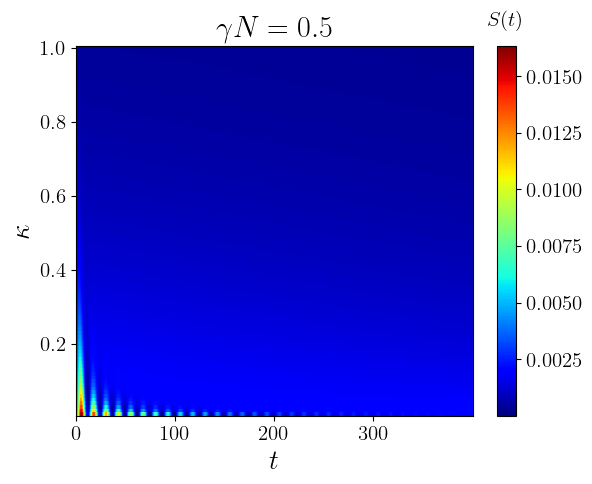

In [369]:
kappa = np.linspace(0.01,1,100)
time = np.arange(m)*dt

x, y = np.meshgrid(time,kappa)

fig, ax = plt.subplots()
####################


#minval = np.min(w_prob[0])
#maxval = np.max(w_prob[0])

im1 = ax.pcolor(x, y, w_prob[0], cmap='jet')

#im1 = ax.contourf(x, y, f_max, levels=np.linspace(minval, maxval,150), cmap="jet")
#CS = ax.contour(x, y, f_max,levels = [0.002,0.01,0.015,0.03,0.05,0.1,0.4],colors ='black',linewidths = 0.7)
###################


cbar = fig.colorbar(
    im1,
    ax=ax,
    #ticks=[0,0.2,0.4,0.6,0.8],
    orientation="vertical"
)
#cbar.ax.set_yticklabels([0,0.2,0.4,0.6,0.8])
cbar.ax.set_title(r'$S(t)$', size = 15,pad = 15)

#manual_locations = [(1,2),(1,2),(1,2),(1,2),(1,2)]

#for level in CS.collections:
    #for kp,path in reversed(list(enumerate(level.get_paths()))):
        # go in reversed order due to deletions!

        # include test for "smallness" of your choice here:
        # I'm using a simple estimation for the diameter based on the
        #    x and y diameter...
        #verts = path.vertices # (N,2)-shape array of contour line coordinates
        #diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
        #print(diameter)

        #if diameter < 0.15: # threshold to be refined for your actual dimensions!
            #if remove_next:
                #del(level.get_paths()[kp])  # no remove() for Path objects:(
            #remove_next = not remove_next  # Toggle the flag
          
#plt.clabel(CS, inline=True, fontsize=10)

plt.xlabel(r'$t$',size = 20)
plt.ylabel(r'$\kappa$',size = 20)
plt.gcf().canvas.draw()
plt.title(r'$\gamma N = 0.5$')
#plt.savefig('../Figures/Phase_Diagram/PD_f_t_kappa_0-1_gammaN_0p5_normalized.png',bbox_inches = 'tight',dpi =600)
plt.show()

#### Max of  $-\frac{d S}{dt}$ as a function of $\gamma$ and $\kappa$



In [96]:
N = 500
w  = 10
kappa = np.linspace(0.01,0.5,40)
gamma = np.linspace(0.5/N,1.5/N,40)

T = 400
dt = 0.01
m  = int(T/dt)

ds_dt_max = np.zeros((len(kappa),len(gamma)))
#T_max = np.zeros((len(kappa),len(gamma)))
s_prob = np.zeros((len(gamma),m))
ds_prob = np.zeros((len(gamma),m - 1))

#target state
ket_w = np.zeros((N,1))
ket_w[w] = 1

for kk in tqdm(range(len(kappa))):

    for k in tqdm(range(len(gamma)),leave = True):
        
        #The Hamiltonian
        H =  sf.H_CG(N,gamma[k],w,kappa[kk])

        #initial state
        psi_0 = (1.0/np.sqrt(N))*np.ones((N,1))

        #Initial overlap
        s_prob[k,0] = np.abs(np.vdot(psi_0,psi_0))

        #Time Evolution operator
        ut = np.asarray(ls.expm(-(1.0j)*H*dt))

        for j in range(1,m):        

            #wavefunction after time evolution of dt
            psit = ut.dot(psi_0)    

            # derivative of survival prob
            s_prob[k,j] = np.abs(np.vdot(psit,psit))
            ds_prob[k,j-1] = s_prob[k,j-1] - s_prob[k,j]
            
            psi_0 = psit  
        
        ds_dt_max[kk,k] = np.max(np.round(ds_prob[k],8))
        #T_max[kk,k] = np.argmax(np.round(ds_prob[k],8))*dt #argmax compute the first maxima

100%|██████████| 40/40 [1:00:59<00:00, 91.48s/it]


In [101]:
with open("../Data/data_surv_prob_max.pkl", "wb") as f:
    pickle.dump(ds_dt_max, f)

#with open("../Data/data_surv_prob_max.pkl", "rb") as f:
#    ds_dt_max = pickle.load(f)

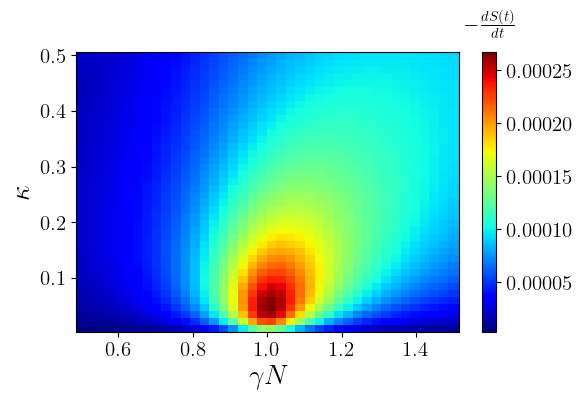

In [110]:
N = 500
kappa = np.linspace(0.01,0.5,40)
gamma = np.linspace(0.5/N,1.5/N,40)

x, y = np.meshgrid(gamma*N, kappa)

fig = plt.figure(figsize = (3.41667*1.4,2*1.4))

# Add axes that cover the entire figure
ax = fig.add_axes([0, 0, 1, 1])

""
####################


minval = 0
maxval = 1
im1 = ax.pcolor(x, y, ds_dt_max, cmap='jet')

#im1 = ax.contourf(x, y, f_m, transparent = Trueax, levels=np.linspace(minval, maxval,150), cmap="jet")
#CS = ax.contour(x, y, f_max,levels = [0.002,0.01,0.015,0.03,0.05,0.1,0.4],colors ='black',linewidths = 0.7)
###################


cbar = fig.colorbar(
    im1,
    ax=ax,
    #ticks=[0,0.2,0.4,0.6,0.8,1.0],
    orientation="vertical"
)
#cbar.ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
cbar.ax.set_title(r'$-\frac{dS(t)}{dt}$', size = 15,pad = 15)

#manual_locations = [(1,2),(1,2),(1,2),(1,2),(1,2)]

#for level in CS.collections:
    #for kp,path in reversed(list(enumerate(level.get_paths()))):
        # go in reversed order due to deletions!

        # include test for "smallness" of your choice here:
        # I'm using a simple estimation for the diameter based on the
        #    x and y diameter...
        #verts = path.vertices # (N,2)-shape array of contour line coordinates
        #diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
        #print(diameter)

        #if diameter < 0.15: # threshold to be refined for your actual dimensions!
            #if remove_next:
                #del(level.get_paths()[kp])  # no remove() for Path objects:(
            #remove_next = not remove_next  # Toggle the flag

            


#plt.clabel(CS, inline=True, fontsize=10)

plt.ylabel(r'$\kappa$',size = 20)
plt.xlabel(r'$\gamma N$',size = 20)


plt.gcf().canvas.draw()

plt.savefig('../Figures/Presentation/PD_fidelity_no_S_t_max_kappa_0-0p5.png',bbox_inches = 'tight',dpi =600,transparent = True)
plt.show()

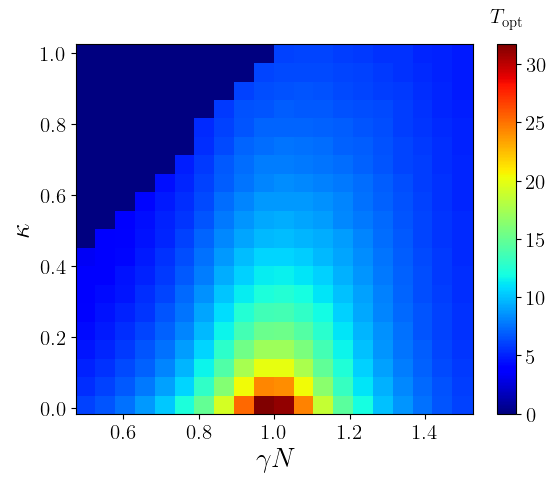

In [168]:
N = 500
kappa = np.linspace(0.01,1,20)
gamma = np.linspace(0.5/N,1.5/N,20)

x, y = np.meshgrid(gamma*N, kappa)

fig, ax = plt.subplots()
####################


minval = 0
maxval = 1

# Mask out regions where z2 equals zero
#T_masked = np.ma.masked_where(T_max == 0, T_max)


im1 = ax.pcolor(x, y, T_max, cmap='jet')

#im1 = ax.contourf(x, y, f_max, levels=np.linspace(minval, maxval,150), cmap="jet")
#CS = ax.contour(x, y, f_max,levels = [0.002,0.01,0.015,0.03,0.05,0.1,0.4],colors ='black',linewidths = 0.7)
###################


cbar = fig.colorbar(
    im1,
    ax=ax,
    #ticks=[0,0.2,0.4,0.6,0.8,1.0],
    orientation="vertical"
)
#cbar.ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
cbar.ax.set_title(r'$T_{\rm opt}$', size = 15,pad = 15)

#manual_locations = [(1,2),(1,2),(1,2),(1,2),(1,2)]

#for level in CS.collections:
    #for kp,path in reversed(list(enumerate(level.get_paths()))):
        # go in reversed order due to deletions!

        # include test for "smallness" of your choice here:
        # I'm using a simple estimation for the diameter based on the
        #    x and y diameter...
        #verts = path.vertices # (N,2)-shape array of contour line coordinates
        #diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
        #print(diameter)

        #if diameter < 0.15: # threshold to be refined for your actual dimensions!
            #if remove_next:
                #del(level.get_paths()[kp])  # no remove() for Path objects:(
            #remove_next = not remove_next  # Toggle the flag

            


#plt.clabel(CS, inline=True, fontsize=10)

plt.ylabel(r'$\kappa$',size = 20)
plt.xlabel(r'$\gamma N$',size = 20)

plt.gcf().canvas.draw()

#plt.savefig('../Figures/Phase_Diagram/PD_fidelity_no_S_t_max_kappa_0-1.png',bbox_inches = 'tight',dpi =600)
plt.show()

#### Max unnormalized Fidelity as a function of $\kappa$ and $\gamma$

In [19]:
N = 500
w  = 10
kappa = np.linspace(0.01,0.5,40)
gamma = np.linspace(0.5/N,1.5/N,40)

T = 400
dt = 0.01
m  = int(T/dt)

f_max = np.zeros((len(kappa),len(gamma)))
T_max = np.zeros((len(kappa),len(gamma)))
w_prob = np.zeros((len(gamma),m))

#target state
ket_w = np.zeros((N,1))
ket_w[w] = 1

for kk in tqdm(range(len(kappa))):

    for k in tqdm(range(len(gamma)),leave = True):
        
        #The Hamiltonian
        H =  sf.H_CG(N,gamma[k],w,kappa[kk])

        #initial state
        psi_0 = (1.0/np.sqrt(N))*np.ones((N,1))

        #Initial overlap
        w_prob[k,0] = (np.abs(np.vdot(ket_w,psi_0))**2) 

        #Time Evolution operator
        ut = np.asarray(ls.expm(-(1.0j)*H*dt))

        for j in range(1,m):        

            #wavefunction after time evolution of dt
            psit = ut.dot(psi_0)    

            # Un-normalized fidelity
            w_prob[k,j] = (np.abs(np.vdot(ket_w,psit))**2) 
            
            psi_0 = psit  
        
        f_max[kk,k] = np.max(np.round(w_prob[k],8))
        T_max[kk,k] = np.argmax(np.round(w_prob[k],8))*dt #argmax compute the first maxima

100%|██████████| 40/40 [1:13:22<00:00, 110.05s/it]


In [38]:
#import pickle
#with open("../Data/data_f_max_no_resetting.pkl", "wb") as f:
#    pickle.dump(f_max, f)

#with open("../Data/data_T_max_no_resetting.pkl", "wb") as f:
#    pickle.dump(T_max, f)

In [38]:
with open("../Data/data_f_max_no_resetting.pkl", "rb") as f:
    f_max = pickle.load(f)

with open("../Data/data_T_max_no_resetting.pkl", "rb") as f:
    T_max = pickle.load(f)    

In [97]:
kappa = np.linspace(0.01,0.5,40)
gamma = np.linspace(0.5/N,1.5/N,40)

Q = np.zeros((len(kappa),len(gamma)))

for i in range(len(kappa)):
    for j in range(len(gamma)):

        Q[i,j] = T_max[i,j]/f_max[i,j]

/tmp/ipykernel_1733019/2833699812.py:15: RuntimeWarning: divide by zero encountered in log
  maxval = np.max(np.log(Q_masked))
/tmp/ipykernel_1733019/2833699812.py:18: RuntimeWarning: divide by zero encountered in log10
  im1 = ax.pcolor(x, y, np.log10(Q_masked), cmap='jet')


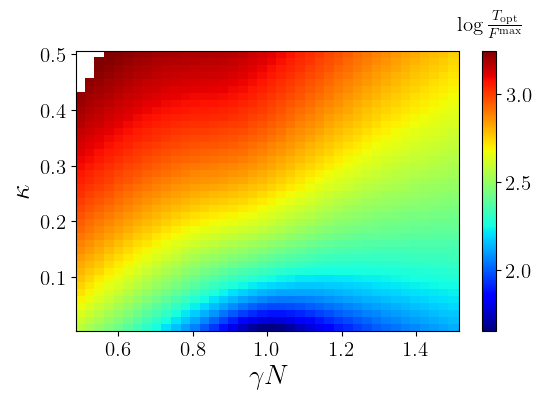

In [111]:
kappa = np.linspace(0.01,0.5,40)
gamma = np.linspace(0.5/N,1.5/N,40)

x, y = np.meshgrid(gamma*N, kappa)


fig= plt.figure(figsize = (3.41667*1.4,2*1.4))
ax = fig.add_axes([0, 0, 1, 1])
####################

# Mask out regions where z2 equals zero
Q_masked = np.ma.masked_where(Q== 0, Q)

minval = np.log(0.01)
maxval = np.max(np.log(Q_masked))

#im1 = ax.contourf(x, y, Q, levels=np.linspace(minval, maxval,150), cmap="jet")
im1 = ax.pcolor(x, y, np.log10(Q_masked), cmap='jet')


#CS = ax.contour(x, y,Q,20,colors ='black',linewidths = 0.7)
###################

cbar = fig.colorbar(
    im1,
    ax=ax,
    #ticks=[0,1000,2000,3000,4000],
    orientation="vertical"
)
#cbar.ax.set_yticklabels([0,1000,2000,3000,4000])
cbar.ax.set_title(r'$\log \frac{T_{\rm opt}}{F^{\rm max}}$', size = 15,pad = 15)

# Overlay striped pattern on regions where z2 is zero
#ax.contourf(x, y, Q, levels=[0.5, 1.5], colors='none', hatches=['\\'], extend='both')


#manual_locations = [(1,2),(1,2),(1,2),(1,2),(1,2)]

#for level in CS.collections:
   # for kp,path in reversed(list(enumerate(level.get_paths()))):
        # go in reversed order due to deletions!

        # include test for "smallness" of your choice here:
        # I'm using a simple estimation for the diameter based on the
        #    x and y diameter...
       # verts = path.vertices # (N,2)-shape array of contour line coordinates
      #  diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
      #  print(diameter)

      #  if diameter != 1999998.0981764845 and diameter != 1980728.364805822 : # threshold to be refined for your actual dimensions!
       #     del(level.get_paths()[kp])  # no remove() for Path objects:(


#plt.clabel(CS, inline=True, fontsize=10)

plt.ylabel(r'$\kappa$',size = 20)
plt.xlabel(r'$\gamma N$',size = 20)

plt.gcf().canvas.draw()


plt.savefig('../Figures/Presentation/PD_complexity_no_S_t_kappa_0-1.png',bbox_inches = 'tight',dpi =600, transparent = True )
plt.show()


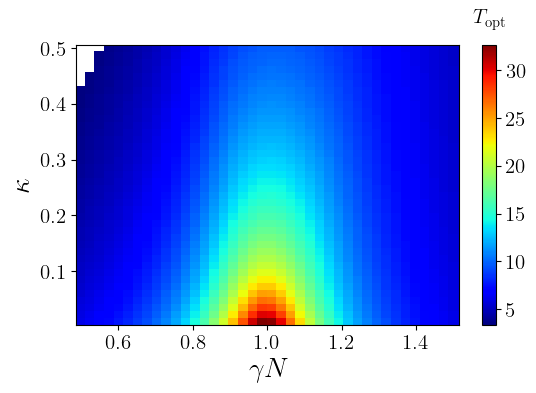

In [112]:
#N = 500
#kappa = np.linspace(0.01,1,40)
#gamma = np.linspace(0.5/N,1.5/N,40)

x, y = np.meshgrid(gamma*N, kappa)

fig= plt.figure(figsize = (3.41667*1.4,2*1.4))
ax = fig.add_axes([0, 0, 1, 1])
####################


minval = 0
maxval = 1

# Mask out regions where z2 equals zero
T_masked = np.ma.masked_where(T_max == 0, T_max)


im1 = ax.pcolor(x, y, T_masked, cmap='jet')

#im1 = ax.contourf(x, y, f_max, levels=np.linspace(minval, maxval,150), cmap="jet")
#CS = ax.contour(x, y, f_max,levels = [0.002,0.01,0.015,0.03,0.05,0.1,0.4],colors ='black',linewidths = 0.7)
###################


cbar = fig.colorbar(
    im1,
    ax=ax,
    #ticks=[0,0.2,0.4,0.6,0.8,1.0],
    orientation="vertical"
)
#cbar.ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
cbar.ax.set_title(r'$T_{\rm opt}$', size = 15,pad = 15)

#manual_locations = [(1,2),(1,2),(1,2),(1,2),(1,2)]

#for level in CS.collections:
    #for kp,path in reversed(list(enumerate(level.get_paths()))):
        # go in reversed order due to deletions!

        # include test for "smallness" of your choice here:
        # I'm using a simple estimation for the diameter based on the
        #    x and y diameter...
        #verts = path.vertices # (N,2)-shape array of contour line coordinates
        #diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
        #print(diameter)

        #if diameter < 0.15: # threshold to be refined for your actual dimensions!
            #if remove_next:
                #del(level.get_paths()[kp])  # no remove() for Path objects:(
            #remove_next = not remove_next  # Toggle the flag

            


#plt.clabel(CS, inline=True, fontsize=10)

plt.ylabel(r'$\kappa$',size = 20)
plt.xlabel(r'$\gamma N$',size = 20)

plt.gcf().canvas.draw()

plt.savefig('../Figures/Presentation/PD_fidelity_no_S_t_max_kappa_0-1.png',bbox_inches = 'tight',dpi =600, transparent = True)
plt.show()

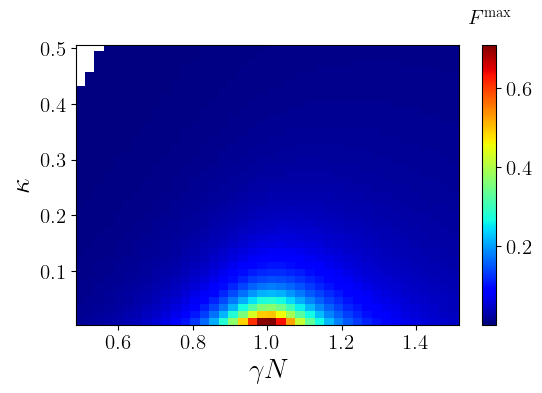

In [113]:
#N = 500
#kappa = np.linspace(0.01,1,40)
#gamma = np.linspace(0.5/N,1.5/N,40)

x, y = np.meshgrid(gamma*N, kappa)

fig= plt.figure(figsize = (3.41667*1.4,2*1.4))
ax = fig.add_axes([0, 0, 1, 1])
####################


minval = 0
maxval = 1

# Mask out regions where z2 equals zero
f_masked = np.ma.masked_where(f_max == 1.0/500, f_max)

im1 = ax.pcolor(x, y, f_masked, cmap='jet')

#im1 = ax.contourf(x, y, f_max, levels=np.linspace(minval, maxval,150), cmap="jet")
#CS = ax.contour(x, y, f_max,levels = [0.002,0.01,0.015,0.03,0.05,0.1,0.4],colors ='black',linewidths = 0.7)
###################


cbar = fig.colorbar(
    im1,
    ax=ax,
    #ticks=[0,0.2,0.4,0.6,0.8,1.0],
    orientation="vertical"
)
#cbar.ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0])
cbar.ax.set_title(r'$F^{\rm max}$', size = 15,pad = 15)

#manual_locations = [(1,2),(1,2),(1,2),(1,2),(1,2)]

#for level in CS.collections:
    #for kp,path in reversed(list(enumerate(level.get_paths()))):
        # go in reversed order due to deletions!

        # include test for "smallness" of your choice here:
        # I'm using a simple estimation for the diameter based on the
        #    x and y diameter...
        #verts = path.vertices # (N,2)-shape array of contour line coordinates
        #diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
        #print(diameter)

        #if diameter < 0.15: # threshold to be refined for your actual dimensions!
            #if remove_next:
                #del(level.get_paths()[kp])  # no remove() for Path objects:(
            #remove_next = not remove_next  # Toggle the flag

            


#plt.clabel(CS, inline=True, fontsize=10)

plt.ylabel(r'$\kappa$',size = 20)
plt.xlabel(r'$\gamma N$',size = 20)

plt.gcf().canvas.draw()

plt.savefig('../Figures/Presentation/PD_fidelity_max_kappa_0-1.png',bbox_inches = 'tight',dpi =600, transparent = True)
plt.show()

#### Introducing resetting in the dynamics

In [142]:
N = 500
w  = 10
kappa = [0.01,0.1,1]
#kappa = [1]
gamma = [0.5/N, 1.0/N, 1.5/N]
#gamma = [1.0/N]

T = 400
dt = 0.01
m  = int(T/dt)

r = [400000,5/0.01,50/0.01,100/0.01]

w_prob = np.zeros((len(r),len(gamma),len(kappa),m))
s_prob = np.zeros((len(r),len(gamma),len(kappa),m))

#target state
ket_w = np.zeros((N,1))
ket_w[w] = 1


for k in range(len(r)):

    for kk in range(len(gamma)):

        for kkk in tqdm(range(len(kappa))):
        
            #The Hamiltonian
            H =  sf.H_CG(N,gamma[kk],w,kappa[kkk])

            #initial state
            psi_0 = (1.0/np.sqrt(N))*np.ones((N,1))

            #reset state
            psi_r = (1.0/np.sqrt(N))*np.ones((N,1))       

            #Initial overlap
            s_prob[k,kk,kkk,0] = np.abs(np.vdot(psi_0,psi_0))
            w_prob[k,kk,kkk,0] = np.abs(np.vdot(ket_w,psi_0))**2

            #Time Evolution operator
            ut = np.asarray(ls.expm(-(1.0j)*H*dt))

            for j in range(1,m): 

                if j%r[k] != 0:       

                    #wavefunction after time evolution of dt
                    psit = ut.dot(psi_0)    

                    #survival probability
                    s_prob[k,kk,kkk,j] = np.abs(np.vdot(psit,psit))
                    w_prob[k,kk,kkk,j] = np.abs(np.vdot(ket_w,psit))**2
                    
                    psi_0 = psit  
                
                else: # reset conditions
                    psi_0 = np.sqrt(s_prob[k,kk,kkk,j-1])*psi_r

                    #survival probability
                    s_prob[k,kk,kkk,j] = np.abs(np.vdot(psi_0,psi_0))
                    w_prob[k,kk,kkk,j] = np.abs(np.vdot(ket_w,psi_0))**2


100%|██████████| 3/3 [00:11<00:00,  3.70s/it]


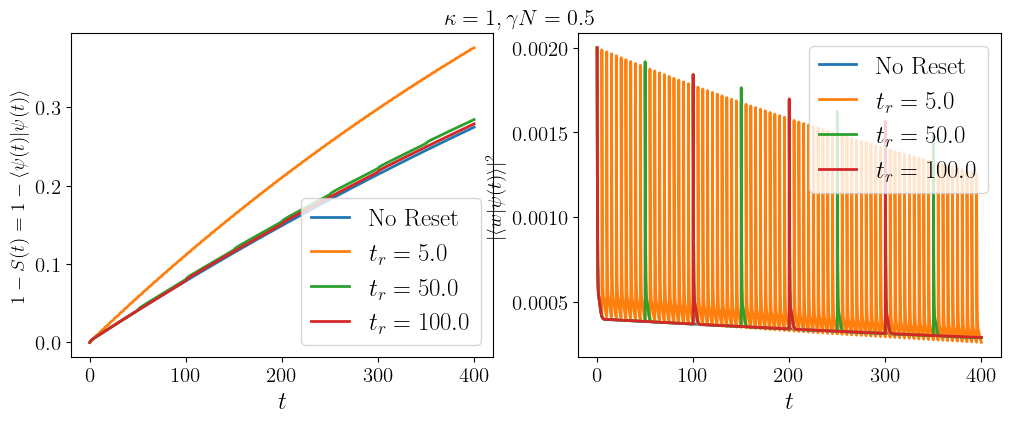

In [164]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 4 columns

#gamma and kappa Indices
g = 0
k = 2

##############################
ax[0].plot(np.arange(m)*dt,1 - s_prob[0,g,k,:],label = r'No Reset')
ax[0].plot(np.arange(m)*dt,1 - s_prob[1,g,k,:],label = f'$t_r = {r[1]*0.01}$')
ax[0].plot(np.arange(m)*dt,1 - s_prob[2,g,k,:],label = f'$t_r = {r[2]*0.01}$')
ax[0].plot(np.arange(m)*dt,1 - s_prob[3,g,k,:],label = f'$t_r = {r[3]*0.01}$')

ax[0].legend(frameon =True,loc = 'lower right')
ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$1 - S(t) = 1 - \langle \psi(t)|\psi(t)\rangle$',fontsize = 14)
#ax[0].set_xscale('log')

##############################
ax[1].plot(np.arange(m)*dt,w_prob[0,g,k,:],label =  r'No Reset')
ax[1].plot(np.arange(m)*dt,w_prob[1,g,k,:],label =  f'$t_r = {r[1]*0.01}$')
ax[1].plot(np.arange(m)*dt,w_prob[2,g,k,:],label = f'$t_r = {r[2]*0.01}$')
ax[1].plot(np.arange(m)*dt,w_prob[3,g,k,:],label = f'$t_r = {r[3]*0.01}$')

ax[1].legend(frameon =True,loc = 'upper right')
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$|\langle w|\psi(t)\rangle|^2$', fontsize = 14)

##############################

# Title for the whole figure
fig.suptitle(f'$\\kappa = {kappa[k]}, \\gamma N = {gamma[g]*N}$', fontsize=16)
fig.subplots_adjust(top=0.92)


plt.savefig(f'../Figures/Resetting/surv_prob_fidelity_resetting_k_{kappa[k]}_gammaN_{gamma[g]*N}.pdf',bbox_inches = 'tight', dpi =600)
plt.show()

#### Resetting Optimization

In [46]:
N = 500
w  = 10
kappa = [0]
#kappa = [1]
gamma = [1.0/N]
#gamma = [1.0/N]

T = 400
dt = 0.01
m  = int(T/dt)

r = np.unique(np.linspace(1,6000,50, dtype =int))

w_prob_coh = np.zeros((len(r),len(gamma),len(kappa),m))
#s_prob = np.zeros((len(r),len(gamma),len(kappa),m))

#target state
ket_w = np.zeros((N,1))
ket_w[w] = 1


for k in tqdm(range(len(r))):

    for kk in range(len(gamma)):

        for kkk in range(len(kappa)):
        
            #The Hamiltonian
            H =  sf.H_CG(N,gamma[kk],w,kappa[kkk])

            #initial state
            psi_0 = (1.0/np.sqrt(N))*np.ones((N,1))

            #reset state
            psi_r = (1.0/np.sqrt(N))*np.ones((N,1))       

            #Initial overlap
            #s_prob[k,kk,kkk,0] = np.abs(np.vdot(psi_0,psi_0))
            w_prob_coh[k,kk,kkk,0] = np.abs(np.vdot(ket_w,psi_0))**2

            #Time Evolution operator
        fig= plt.figure(figsize = (3.41667*1.4,2*1.4))
ax = fig.add_axes([0, 0, 1, 1])    ut = np.asarray(ls.expm(-(1.0j)*H*dt))

            for j in range(1,m): 

                if j%r[k] != 0:       

                    #wavefunction after time evolution of dt
                    psit = ut.dot(psi_0)    

                    #survival probability
                    #s_prob[k,kk,kkk,j] = np.abs(np.vdot(psit,psit))
                    w_prob_coh[k,kk,kkk,j] = np.abs(np.vdot(ket_w,psit))**2
                    
                    psi_0 = psit  
                
                else: # reset conditions
                    psi_0 = psi_r

                    #survival probability
                    #s_prob[k,kk,kkk,j] = np.abs(np.vdot(psi_0,psi_0))
                    w_prob_coh[k,kk,kkk,j] = np.abs(np.vdot(ket_w,psi_0))**2

100%|██████████| 50/50 [01:48<00:00,  2.17s/it]


In [47]:
r1 = np.unique(np.linspace(1,6000,50, dtype =int))

#gamma indices
g = 0

f_max_coh_r0 = np.zeros(len(r1))
T_max_coh_r0 = np.zeros(len(r1))

for i in range(len(r1)):

    f_max_coh_r0[i]  = np.max(np.round(w_prob_coh[i,g,0,:],8))
    T_max_coh_r0[i] = np.argmax(np.round(w_prob_coh[i,g,0,:],8))*dt #argmax compute the first maxima


Q_coh_r0 = np.zeros(len(r1))

for i in range(len(r1)):
     Q_coh_r0[i] =  T_max_coh_r0[i]/ f_max_coh_r0[i]

In [48]:
N = 500
w  = 10
kappa = [0.01,0.1,1]
#kappa = [1]
#gamma = [0.5/N, 1.0/N, 1.5/N]
gamma = [1.0/N]

T = 400
dt = 0.01
m  = int(T/dt)

r = np.unique(np.linspace(1,6000,50, dtype =int))

w_prob = np.zeros((len(r),len(gamma),len(kappa),m))
s_prob = np.zeros((len(r),len(gamma),len(kappa),m))

#target state
ket_w = np.zeros((N,1))
ket_w[w] = 1


for k in tqdm(range(len(r))):

    for kk in range(len(gamma)):

        for kkk in range(len(kappa)):
        
            #The Hamiltonian
            H =  sf.H_CG(N,gamma[kk],w,kappa[kkk])

            #initial state
            psi_0 = (1.0/np.sqrt(N))*np.ones((N,1))

            #reset state
            psi_r = (1.0/np.sqrt(N))*np.ones((N,1))       

            #Initial overlap
            s_prob[k,kk,kkk,0] = np.abs(np.vdot(psi_0,psi_0))
            w_prob[k,kk,kkk,0] = np.abs(np.vdot(ket_w,psi_0))**2

            #Time Evolution operator
            ut = np.asarray(ls.expm(-(1.0j)*H*dt))

            for j in range(1,m): 

                if j%r[k] != 0:       

                    #wavefunction after time evolution of dt
                    psit = ut.dot(psi_0)    

                    #survival probability
                    s_prob[k,kk,kkk,j] = np.abs(np.vdot(psit,psit))
                    w_prob[k,kk,kkk,j] = np.abs(np.vdot(ket_w,psit))**2
                    
                    psi_0 = psit  
                
                else: # reset conditions
                    psi_0 = np.sqrt(s_prob[k,kk,kkk,j-1])*psi_r

                    #survival probability
                    s_prob[k,kk,kkk,j] = np.abs(np.vdot(psi_0,psi_0))
                    w_prob[k,kk,kkk,j] = np.abs(np.vdot(ket_w,psi_0))**2


100%|██████████| 50/50 [06:18<00:00,  7.57s/it]


In [50]:
r = np.unique(np.linspace(1,6000,50, dtype =int))*0.01

#gamma and kappa indices
g = 0
k = 2

f_max_r02 = np.zeros(len(r))
T_max_r02 = np.zeros(len(r))

for i in range(len(r)):

    f_max_r02[i]  = np.max(np.round(w_prob[i,g,k,:],8))
    T_max_r02[i] = np.argmax(np.round(w_prob[i,g,k,:],8))*dt #argmax compute the first maxima


Q_r01 = np.zeros(len(r))

for i in range(len(r)):
     Q_r01[i] = T_max_r01[i]/f_max_r01[i]

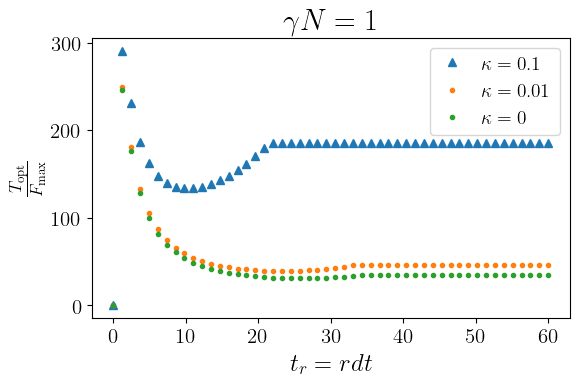

In [116]:
fig= plt.figure(figsize = (3.41667*1.4,2*1.4))
ax = fig.add_axes([0, 0, 1, 1])

r = np.unique(np.linspace(1,6000,50, dtype =int))*0.01


plt.plot(r,Q_r01,'^' ,label = f'$\\kappa = 0.1$')
plt.plot(r,Q_r00,'.' ,label = f'$\\kappa = 0.01$')
plt.plot(r1*0.01,Q_coh_r0 ,'.' ,label = f'$\\kappa = 0$')
plt.title(f'$\gamma N = 1$')
plt.legend(frameon =True,loc = 0)
plt.ylabel(r'$\frac{T_{\rm opt}}{F_{\rm max}}$')
plt.xlabel(r'$t_r = r dt$')

plt.savefig(r'../Figures/Presentation/complexity_with_resetting_gammaN_1_no_kappa.pdf',bbox_inches = 'tight', dpi =600, transparent = True)
plt.show()

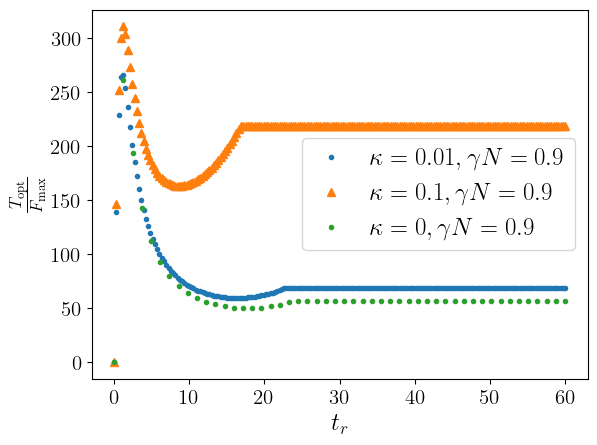

In [36]:
r = np.unique(np.linspace(1,6000,200, dtype =int))*0.01
plt.plot(r,Q_r00,'.' ,label = f'$\\kappa = 0.01, \\gamma N = {gamma[0]*N}$')
plt.plot(r,Q_r01,'^' ,label = f'$\\kappa = 0.1, \\gamma N = {gamma[0]*N}$')
plt.plot(r1*0.01,Q_coh_r0 ,'.' ,label = f'$\\kappa = 0, \\gamma N = {gamma[0]*N}$')

plt.legend(frameon =True)
plt.ylabel(r'$\frac{T_{\rm opt}}{F_{\rm max}}$')
plt.xlabel(r'$t_r$')

plt.savefig(r'../Figures/Resetting/complexity_with_resetting_gammaN_0p9_no_kappa.pdf',bbox_inches = 'tight', dpi =600)
plt.show()

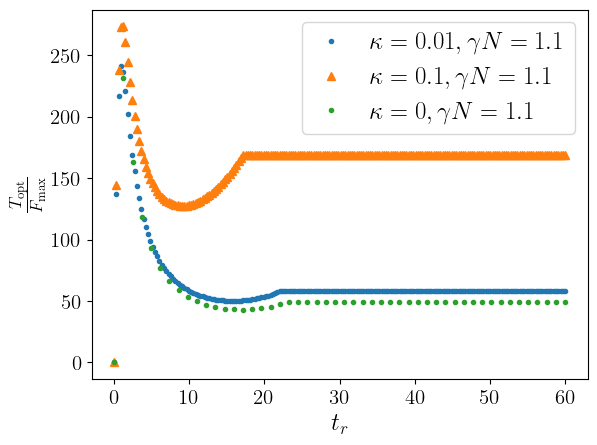

In [45]:
r = np.unique(np.linspace(1,6000,200, dtype =int))*0.01
plt.plot(r,Q_r20,'.' ,label = f'$\\kappa = 0.01, \\gamma N = {gamma[2]*N}$')
plt.plot(r,Q_r21,'^' ,label = f'$\\kappa = 0.1, \\gamma N = {gamma[2]*N}$')
plt.plot(r1*0.01,Q_coh_r2 ,'.' ,label = f'$\\kappa = 0, \\gamma N = {gamma[2]*N}$')

plt.legend(frameon =True)
plt.ylabel(r'$\frac{T_{\rm opt}}{F_{\rm max}}$')
plt.xlabel(r'$t_r$')

plt.savefig(r'../Figures/Resetting/complexity_with_resetting_gammaN_1p1_no_kappa.pdf',bbox_inches = 'tight', dpi =600)
plt.show()

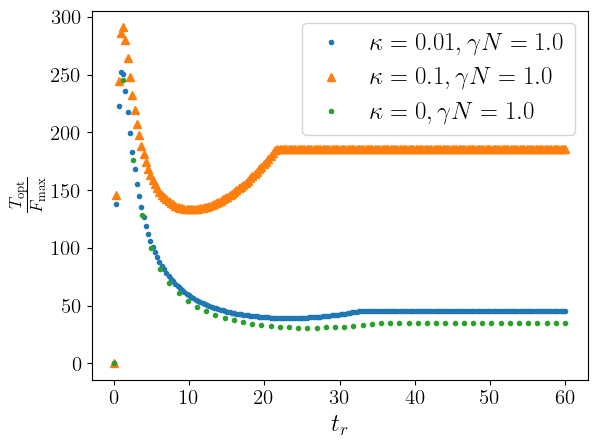

In [41]:
r = np.unique(np.linspace(1,6000,200, dtype =int))*0.01
plt.plot(r,Q_r10,'.' ,label = f'$\\kappa = 0.01, \\gamma N = {gamma[1]*N}$')
plt.plot(r,Q_r11,'^' ,label = f'$\\kappa = 0.1, \\gamma N = {gamma[1]*N}$')
plt.plot(r1*0.01,Q_coh_r1 ,'.' ,label = f'$\\kappa = 0, \\gamma N = {gamma[1]*N}$')

plt.legend(frameon =True)
plt.ylabel(r'$\frac{T_{\rm opt}}{F_{\rm max}}$')
plt.xlabel(r'$t_r$')

plt.savefig(r'../Figures/Resetting/complexity_with_resetting_gammaN_1_no_kappa.pdf',bbox_inches = 'tight', dpi =600)
plt.show()

#### Time for Survival probability decay to $0.5$ as a function of resetting time

In [77]:
def find_transition_point(arr):
    left, right = 0, len(arr) - 1
    
    while left < right:
        mid = (left + right) // 2
        if arr[mid] > 0.5:
            left = mid + 1  # Search in the right half
        else:
            right = mid  # Search in the left half
            
    return left if arr[left] <= 0.5 else 0  # Return index or 0 if no transition

In [80]:
r = np.unique(np.linspace(1,6000,200, dtype =int))*0.01
#gamma and kappa indices
g = 1
k = 2

T_decay_r12 = np.zeros(len(r))

for i in range(len(r)):

    T_decay_r12[i]  = find_transition_point(s_prob[i,g,k,:])*0.01


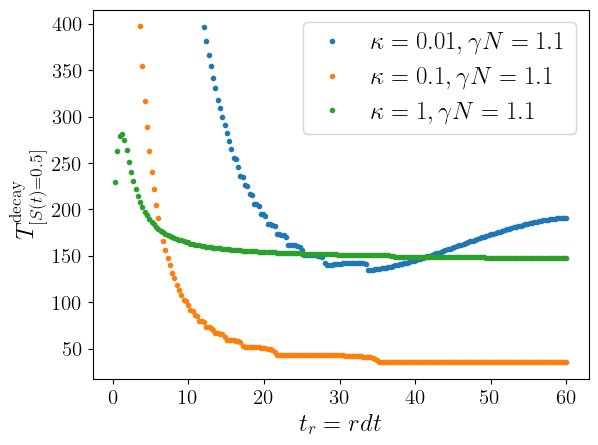

In [21]:
r = np.unique(np.linspace(1, 6000, 200, dtype=int)) * 0.01
N = 500
kappa = [0.01, 0.1, 0.5]
gamma = [0.9/N, 1.0/N, 1.1/N]

# Filter nonzero values
mask0 = T_decay_r20 != 0
mask1 = T_decay_r21 != 0
mask2 = T_decay_r22 != 0

plt.plot(r[mask0], T_decay_r20[mask0], '.', label=f'$\\kappa = {kappa[0]}, \\gamma N = {gamma[2]*N}$')
plt.plot(r[mask1], T_decay_r21[mask1], '.', label=f'$\\kappa = {kappa[1]}, \\gamma N = {gamma[2]*N}$')
plt.plot(r[mask2], T_decay_r22[mask2], '.', label=f'$\\kappa = {kappa[2]}, \\gamma N = {gamma[2]*N}$')

plt.legend(frameon=True)
plt.ylabel(r'$T^{\rm decay}_{[S(t) = 0.5]}$')
plt.xlabel(r'$t_r = r dt$')

plt.savefig(r'../Figures/Resetting/surv_prob_complexity_with_resetting_gammaN_1p1.pdf',bbox_inches = 'tight', dpi =600)
plt.show()

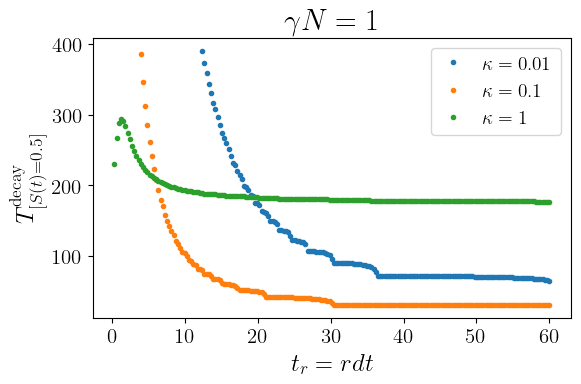

In [117]:
fig= plt.figure(figsize = (3.41667*1.4,2*1.4))
ax = fig.add_axes([0, 0, 1, 1])

r = np.unique(np.linspace(1, 6000, 200, dtype=int)) * 0.01
N = 500
kappa = [0.01, 0.1, 1]
gamma = [0.9/N, 1.0/N, 1.1/N]

# Filter nonzero values
mask0 = T_decay_r10 != 0
mask1 = T_decay_r11 != 0
mask2 = T_decay_r12 != 0

plt.plot(r[mask0], T_decay_r10[mask0], '.', label=f'$\\kappa = {kappa[0]}$')
plt.plot(r[mask1], T_decay_r11[mask1], '.', label=f'$\\kappa = {kappa[1]}$')
plt.plot(r[mask2], T_decay_r12[mask2], '.', label=f'$\\kappa = {kappa[2]}$')

plt.title('$\gamma N = 1$')
plt.legend(frameon=True)
plt.ylabel(r'$T^{\rm decay}_{[S(t) = 0.5]}$')
plt.xlabel(r'$t_r = r dt$')

plt.savefig(r'../Figures/Presentation/surv_prob_complexity_with_resetting_gammaN_1.pdf',bbox_inches = 'tight', dpi =600, transparent = True)
plt.show()

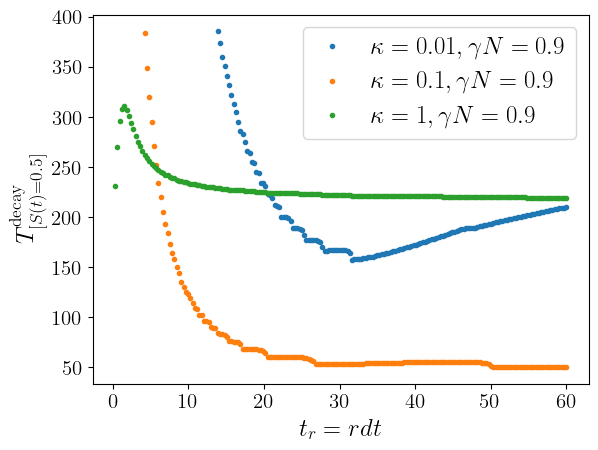

In [23]:
r = np.unique(np.linspace(1, 6000, 200, dtype=int)) * 0.01
N = 500
kappa = [0.01, 0.1, 1]
gamma = [0.9/N, 1.0/N, 1.1/N]

# Filter nonzero values
mask0 = T_decay_r00 != 0
mask1 = T_decay_r01 != 0
mask2 = T_decay_r02 != 0

plt.plot(r[mask0], T_decay_r00[mask0], '.', label=f'$\\kappa = {kappa[0]}, \\gamma N = {gamma[0]*N}$')
plt.plot(r[mask1], T_decay_r01[mask1], '.', label=f'$\\kappa = {kappa[1]}, \\gamma N = {gamma[0]*N}$')
plt.plot(r[mask2], T_decay_r02[mask2], '.', label=f'$\\kappa = {kappa[2]}, \\gamma N = {gamma[0]*N}$')

plt.legend(frameon=True)
plt.ylabel(r'$T^{\rm decay}_{[S(t) = 0.5]}$')
plt.xlabel(r'$t_r = r dt$')

plt.savefig(r'../Figures/Resetting/surv_prob_complexity_with_resetting_gammaN_0p9.pdf',bbox_inches = 'tight', dpi =600)
plt.show()

In [3]:
import pickle

#with open("../Data/data_complexity_resetting.pkl", "wb") as f:
#    pickle.dump(w_prob, f)


In [76]:
with open("../Data/data_surv_prob_complexity_resetting.pkl", "rb") as f:
    s_prob = pickle.load(f)

In [24]:
with open("../Data/data_complexity_resetting.pkl", "rb") as f:
    w_prob = pickle.load(f)

In [332]:
#import pickle

#with open("../Data/data_surv_prob_complexity_resetting.pkl", "wb") as f:
#    pickle.dump(s_prob, f)